# [WK] Projekt 1 - Reprezentacja i przetwarzanie obrazu: Creating a clean plate
#### Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395), Daniel Zdancewicz (145317)

## Funkcje pomocnicze

In [261]:
# import niezbędnych bibliotek
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
import json
import os

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [262]:
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
      if a.shape[2] == 4:
        a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
      else:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

## Pobranie datasetu

In [263]:
# pobranie niezbędnych bibliotek
!wget -O cathedral.zip https://grail.cs.washington.edu/projects/photomontage/data/cathedral.zip && unzip -o cathedral.zip

--2023-04-15 16:07:27--  https://grail.cs.washington.edu/projects/photomontage/data/cathedral.zip
Resolving grail.cs.washington.edu (grail.cs.washington.edu)... 128.208.5.93, 2607:4000:200:14::5d
Connecting to grail.cs.washington.edu (grail.cs.washington.edu)|128.208.5.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1342082 (1.3M) [application/zip]
Saving to: ‘cathedral.zip’

cathedral.zip       100%[===================>]   1.28M  3.40MB/s    in 0.4s    

2023-04-15 16:07:28 (3.40 MB/s) - ‘cathedral.zip’ saved [1342082/1342082]

Archive:  cathedral.zip
  inflating: cathedral/d001.jpg      
  inflating: cathedral/d002.jpg      
  inflating: cathedral/d003.jpg      
  inflating: cathedral/d004.jpg      
  inflating: cathedral/d005.jpg      
  inflating: cathedral/result.png    


In [264]:
resources = './cathedral'

## Dostępne obrazy i oczekiwany wynik końcowy
Celem zadania jest odtworzenie czystego planu katedry, czyli wymazania obiektów występujących na pierwszym planie - w tym przypadku przechodzących ludzi.

0


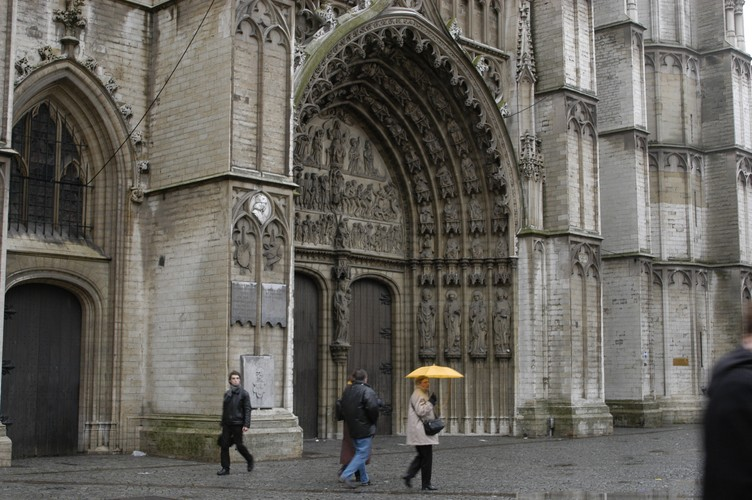

1


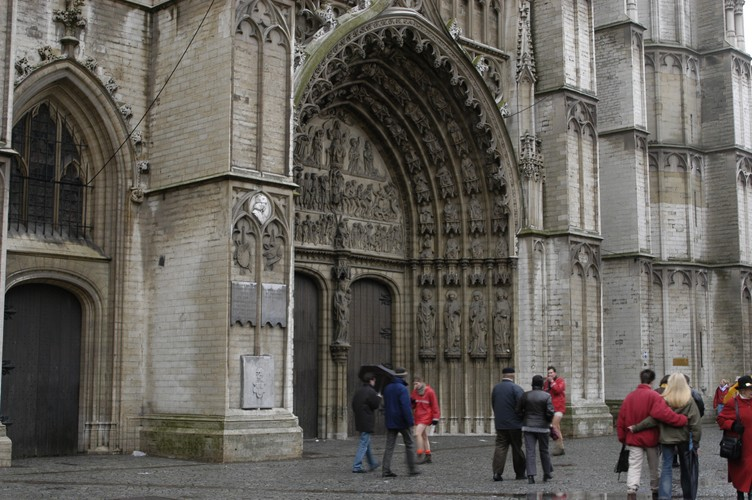

2


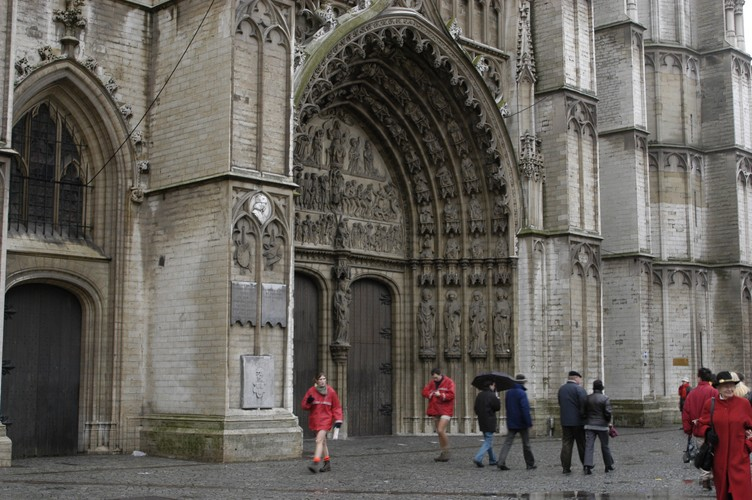

3


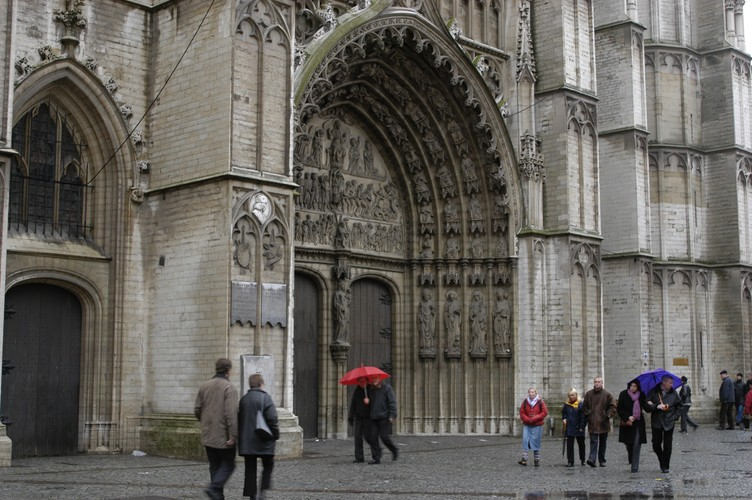

4


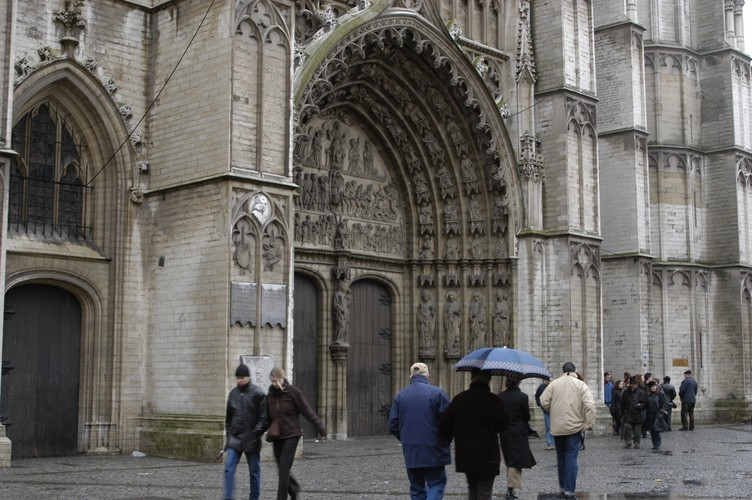

In [265]:
images = [cv2.imread(f"{resources}/d00{i}.jpg") for i in range(1, 6)]
for i, image in enumerate(images):
  print(i)
  imshow(image)

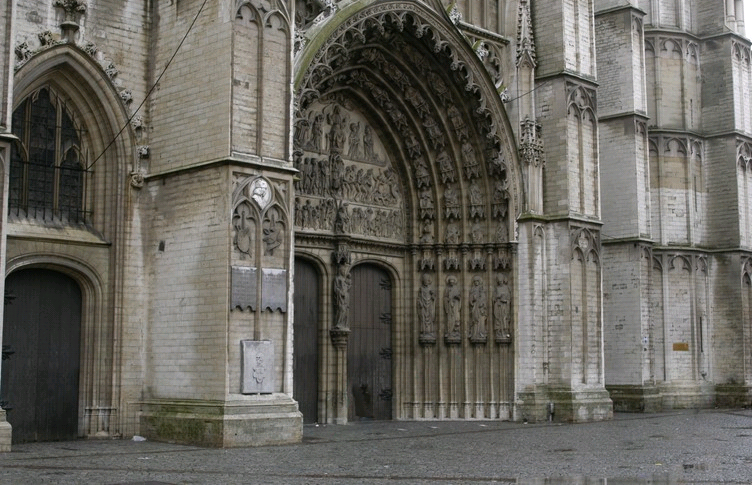

In [266]:
img_result = cv2.imread(f"{resources}/result.png", 1)
imshow(img_result)

## #1. Proste podejścia

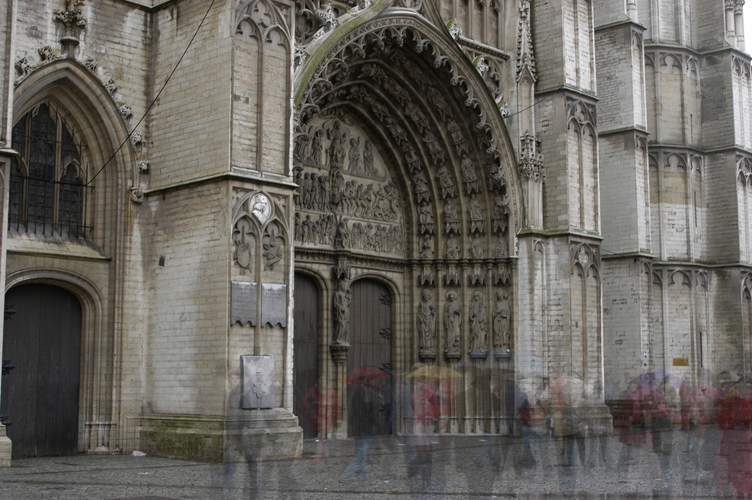

In [267]:
mean_of_images = np.mean(images, axis=0)
imshow(mean_of_images)

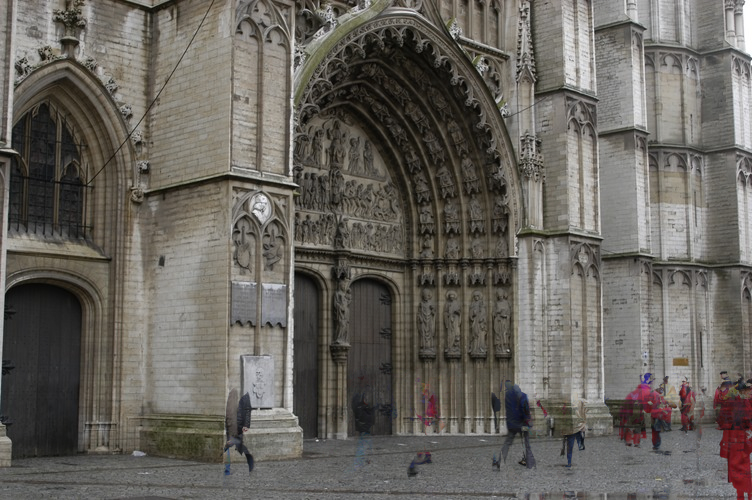

In [268]:
median_of_images = np.median(images, axis=0)
imshow(median_of_images)

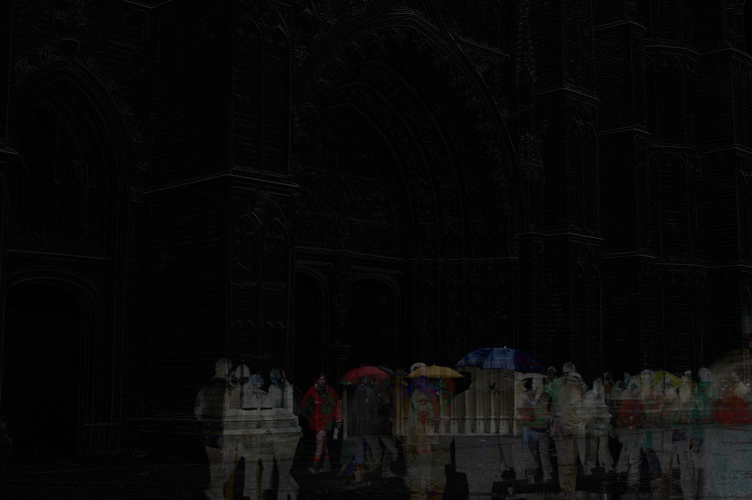

In [269]:
std_of_images = np.std(images, axis=0)
imshow(std_of_images)

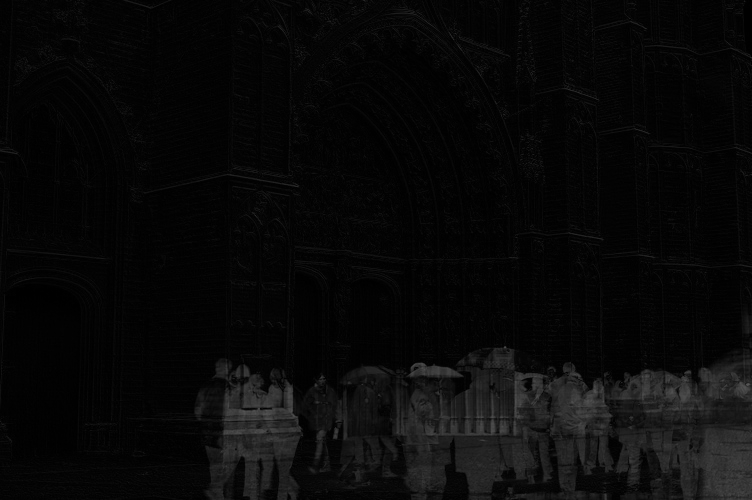

In [270]:
std_of_images_grayscale = cv2.cvtColor(std_of_images.astype(np.uint8), cv2.COLOR_BGR2GRAY)
imshow(std_of_images_grayscale)

## #2. Wybór pixeli najbliżej średniej wartości RGB

Średnia wartość RBG z obrazów:
[ 93.47671968  99.07958191 102.41449521]

Obliczenie odległości dla poszczególnych obrazów:
(5, 500, 752)

Wybranie najbliższych pixeli z poszczególnych obrazów:
(500, 752)



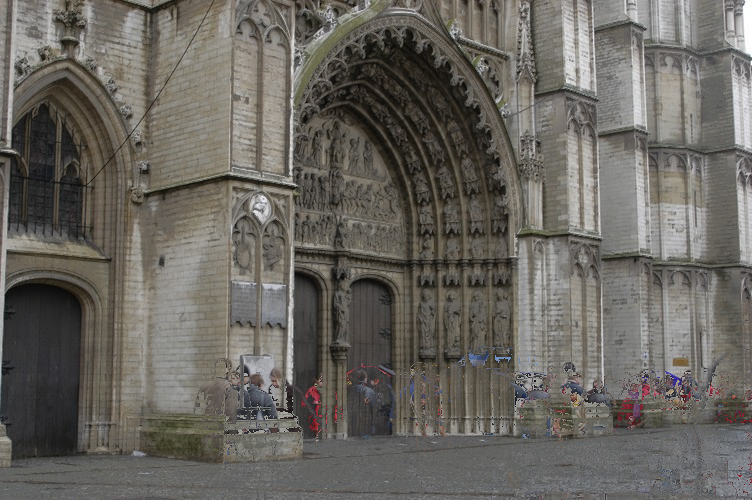

In [271]:
mean_of_images = np.mean(images, axis=(0, 1, 2))
print(f"Średnia wartość RBG z obrazów:\n{mean_of_images}\n")

distances = np.sum(np.square(images - mean_of_images), axis=-1)
print(f"Obliczenie odległości dla poszczególnych obrazów:\n{np.shape(distances)}\n")

pixels_indices = np.argmin(distances, axis=0)
print(f"Wybranie najbliższych pixeli z poszczególnych obrazów:\n{np.shape(pixels_indices)}\n")

result_shape = np.shape(images[0])
closest_to_mean_image = np.zeros(result_shape)

for x in range(result_shape[0]):
  for y in range(result_shape[1]):
    closest_to_mean_image[x][y] = images[pixels_indices[x][y]][x][y]

imshow(closest_to_mean_image)

In [272]:
import cv2

def Q(img_bin, struct):
  x = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  return np.minimum(img_bin, x)


def G(img_bin, struct):
  x = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  return np.maximum(img_bin, x)

def A(image, kernel):
  x = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, kernel)
  return np.maximum(x, Q(image, kernel))

In [273]:
def create_gaussian_kernel(size, sig=3.0):
  center = size // 2
  x, y = np.mgrid[0:size, 0:size]
  g = np.exp(-((x - center) ** 2 + (y - center) ** 2) / (2 * sig ** 2))
  return g / g.sum()

def create_ones_kernel(size):
  return np.ones((size, size))

def create_sharpness_kernel():
  return np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])


def convolved(f, g):
  pad_v = (g.shape[0] - 1) // 2
  pad_h = (g.shape[1] - 1) // 2
  fb = cv2.copyMakeBorder(f, pad_v, pad_v, pad_h, pad_h, cv2.BORDER_CONSTANT, 0)
  fg_cv = cv2.filter2D(fb.astype(g.dtype), -1, g)
  return fg_cv[pad_v:fb.shape[0] - pad_v, pad_h:fb.shape[1] - pad_h]

In [274]:
def as_grayscale(image):
  return np.dot(image[..., :3], [0.299, 0.587, 0.114])
def as_sepia(image):
  return np.dot(image[..., :3], [0.393, 0.769, 0.189])

In [275]:
# kernels
ones_kernel = create_ones_kernel(5)
gaussian_kernel = create_gaussian_kernel(5)
sharpness_kernel = create_sharpness_kernel()


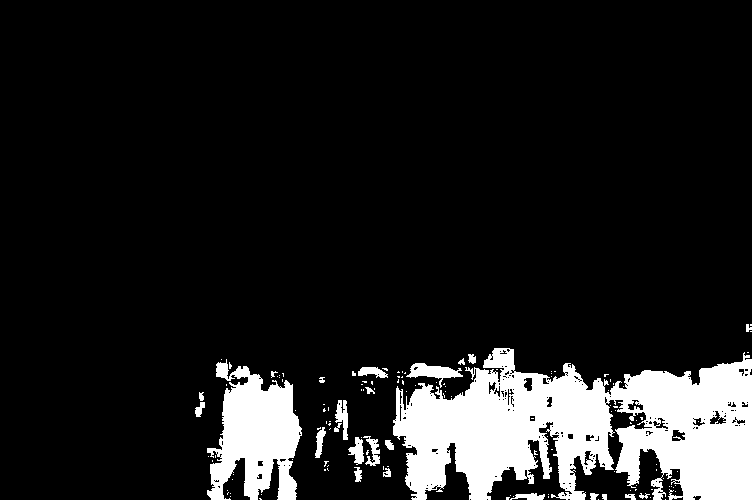

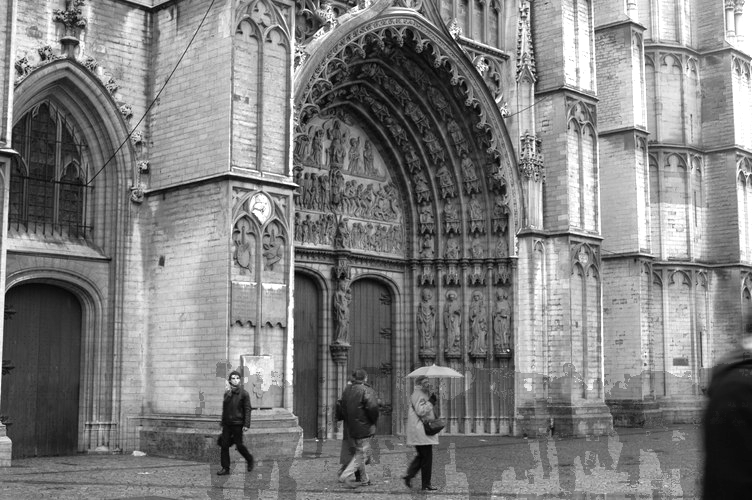

In [276]:
mask = np.std(images, axis=0)
mask = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_BGR2GRAY)

threshold = 23
mask[mask >= threshold] = 255
mask[mask < threshold] = 0

mask = mask.astype(np.uint8)
mask = Q(A(mask, ones_kernel), gaussian_kernel)
imshow(mask)
imshow(mask * as_grayscale(images[0]) / 255 + as_sepia(images[0]) * (1 - mask / 255))

## #3. Wybór najczęściej występujących pixeli z pewną tolerancją - wyszukiwanie dominant

In [277]:
# długo trwa (z 8 min)
def find_dominating_pixels(pixels, tolerance=0.15):
  results = [[pixels[i]] for i in range(pixels.shape[0])]
  items = [0 for _ in range(pixels.shape[0])]
  for i in range(pixels.shape[0]):
    for j in range(pixels.shape[0]):
      if i != j:
        similar = True
        for color1 in pixels[i]:
          for color2 in pixels[j]:
            if not color2 * (1 - tolerance) <= color1 <= color2 * (1 + tolerance):
              similar = False

        if similar:
          results[i].append(pixels[j])
          items[i] += 1

  result = results[np.argmax(items)]
  return np.mean(result, axis=0)


# result_shape = np.shape(images[0])
# dominant_based_image = np.zeros(result_shape)

# for x in range(result_shape[0]):
#   for y in range(result_shape[1]):
#     pixels = np.array([images[i][x][y] for i in range(len(images))])
#     dominant_based_image[x][y] = find_dominating_pixels(pixels)

# imshow(dominant_based_image)

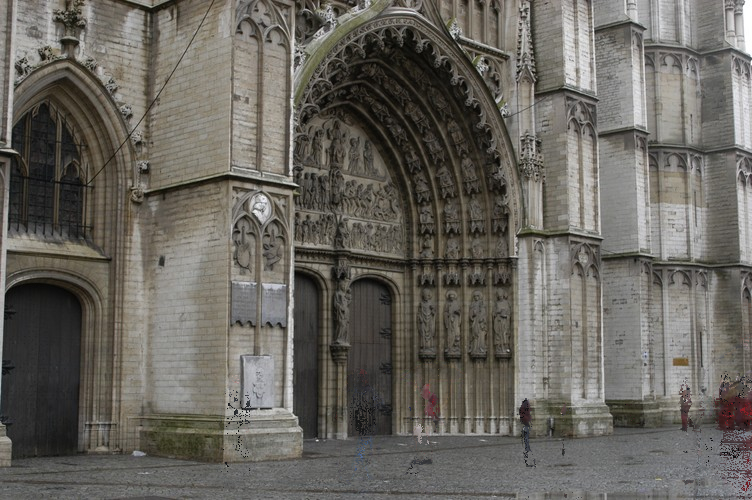

In [279]:
# wymaga refaktoru!
def find_dominating_pixel(pixels, tolerance=0.15):
    pixel_results = {}
    pixel_results[tuple(pixels[0])] = 1
    for pixel in pixels[1:]:
        should_continue = False
        for key in pixel_results.keys():
            truths = [r * (1 - tolerance) <= rp <= r * (1 + tolerance) for r, rp in zip(key, pixel)]
            if all(truths):
                pixel_results[key] += 1
                should_continue = True
                break
        if should_continue:
            continue
        else:
          pixel_results[tuple(pixel)] = 1
    check_point = [True if value == 1 else False for value in pixel_results.values()]
    if all(check_point):
        return list(np.mean(pixels, axis=0).astype(np.int32))

    return max(pixel_results, key=lambda x: pixel_results[x])

flatten_images = np.array([image.reshape(-1, 3) for image in images])
dominant_based_image = []

for point in range(flatten_images[0].shape[0]):
    pixels = [flatten_images[i][point] for i in range(len(images))]
    dominant_based_image.append(find_dominating_pixel(pixels))

dominant_based_image = np.array(dominant_based_image)
dominant_based_image = dominant_based_image.reshape((500, 752, 3))
imshow(dominant_based_image)